In [ ]:
!pip install pyscf
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from pyscf import gto, scf
import matplotlib.pyplot as plt

# =============================================
# Molecular Structures (Naissery Parameters)
# =============================================

# Cisplatin (activated form: [Pt(NH3)2(H2O)2]^2+)
cisplatin = """
Pt 0.0 0.0 0.0
N 0.0 0.0 2.0
N 0.0 2.0 0.0
O 2.0 0.0 0.0
O 0.0 0.0 -2.0
H 0.0 1.0 2.0
H 0.0 -1.0 2.0
H 1.0 2.0 0.0
H -1.0 2.0 0.0
"""

# Lung Cancer DNA Target (1,2-intrastrand d(GpG) crosslink)
# Using N7 positions of guanine where cisplatin binds
dna_gg = """
N 1.8 0.0 0.0  # N7 position of first guanine
N 3.6 0.0 0.0  # N7 position of second guanine
P 2.7 0.0 1.0  # Phosphate backbone
O 2.7 1.0 1.5
O 2.7 -1.0 1.5
O 1.8 0.0 -1.0
O 3.6 0.0 -1.0
H 1.8 0.0 1.0  # Added H to ensure even electron count
"""

# Off-Target Molecules (simplified structures)
# Hair follicle (keratin fragment with even electron count)
hair_follicle = """
C 0.0 0.0 0.0
C 0.0 0.0 1.4
C 1.2 0.0 2.1
O 2.4 0.0 1.6
N 1.2 0.0 3.5
H 0.9 0.0 -0.5
H -1.0 0.0 -0.5
H 0.3 0.0 4.0
H 2.1 0.0 3.9
H 1.2 0.0 0.7  # Added H to ensure even electron count
"""

# Bone marrow (hematopoietic stem cell marker)
bone_marrow = """
C 0.0 0.0 0.0
C 0.0 0.0 1.4
C 1.2 0.0 2.1
C 2.4 0.0 1.4
C 2.4 0.0 0.0
C 1.2 0.0 -0.7
O 3.6 0.0 2.1
N 1.2 0.0 3.5
H -1.0 0.0 -0.5
H 3.3 0.0 -0.6
H 1.2 0.0 -1.8
H 3.6 0.0 3.0  # OH hydrogen
H 0.3 0.0 4.0  # NH hydrogen
"""

# Kidney (urea - kidney toxicity proxy)
kidney = """
C 0.0 0.0 0.0
O 0.0 0.0 1.2
N 1.2 0.0 -0.7
N -1.2 0.0 -0.7
H 1.2 0.0 -1.7
H 2.1 0.0 -0.2
H -1.2 0.0 -1.7
H -2.1 0.0 -0.2
"""

# =============================================
# Quantum Chemistry Calculations with PySCF
# =============================================

def calculate_hamiltonian(mol_xyz, charge=0, name=""):
    """Calculate electronic Hamiltonian for a molecule using PySCF."""
    print(f"\nCalculating Hamiltonian for {name}...")

    # First create a temporary molecule to check electron count
    temp_mol = gto.M(
        atom=mol_xyz,
        basis={'Pt': 'lanl2dz', 'N': '6-31g', 'O': '6-31g',
               'C': '6-31g', 'H': '6-31g', 'P': '6-31g'},
        charge=charge,
        verbose=0
    )

    # Calculate total number of electrons
    total_electrons = sum(temp_mol.atom_charges()) - charge
    print(f"Total electrons: {total_electrons}")

    # Determine appropriate spin based on electron count
    spin = 0
    if total_electrons % 2 == 1:  # Odd number of electrons
        spin = 1
        print(f"Odd electron count, setting spin = 1")
    else:  # Even number of electrons
        spin = 0
        print(f"Even electron count, setting spin = 0")

    # Create the actual molecule with correct spin
    mol = gto.M(
        atom=mol_xyz,
        basis={'Pt': 'lanl2dz', 'N': '6-31g', 'O': '6-31g',
               'C': '6-31g', 'H': '6-31g', 'P': '6-31g'},
        charge=charge,
        spin=spin,
        verbose=0
    )

    # Run SCF calculation - use UHF for odd electron counts
    if spin == 0:
        mf = scf.RHF(mol)
    else:
        mf = scf.UHF(mol)
        print(f"Using unrestricted Hartree-Fock for open-shell system")

    mf.kernel()

    if not mf.converged:
        print(f"Warning: SCF did not converge for {name}!")
        # Try with a different algorithm
        if spin == 0:
            mf = scf.RHF(mol).newton()
        else:
            mf = scf.UHF(mol).newton()
        mf.kernel()
        if mf.converged:
            print(f"Convergence achieved with Newton-Raphson method")
        else:
            print(f"Still could not achieve convergence")
    else:
        print(f"SCF converged successfully for {name}")

    # Get Hamiltonian
    h_core = mf.get_hcore()

    # Print information about the Hamiltonian
    print(f"Hamiltonian shape: {h_core.shape}")
    print(f"Hamiltonian trace: {np.trace(h_core)}")
    print(f"Hamiltonian min: {np.min(h_core)}, max: {np.max(h_core)}")
    print(f"Number of basis functions: {mol.nao}")
    print(f"Nuclear repulsion energy: {mol.energy_nuc()}")

    # For UHF, we have alpha and beta orbitals
    if spin != 0:
        print(f"Alpha electrons: {mol.nelec[0]}, Beta electrons: {mol.nelec[1]}")
        mo_energy = (mf.mo_energy[0], mf.mo_energy[1])  # Alpha and beta orbital energies
    else:
        mo_energy = mf.mo_energy

    # Visualize the Hamiltonian matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(h_core, cmap='viridis')
    plt.colorbar(label='Energy (a.u.)')
    plt.title(f'Hamiltonian Matrix for {name}')
    plt.xlabel('Basis Function Index')
    plt.ylabel('Basis Function Index')
    plt.savefig(f'hamiltonian_{name.lower().replace(" ", "_")}.png')
    plt.close()

    return h_core, mf.mo_coeff, mo_energy

# Calculate Hamiltonians for all systems
h_cisplatin, mo_cisplatin, e_cisplatin = calculate_hamiltonian(cisplatin, charge=2, name="Cisplatin")
h_dna_gg, mo_dna_gg, e_dna_gg = calculate_hamiltonian(dna_gg, name="DNA-GG")
h_hair, mo_hair, e_hair = calculate_hamiltonian(hair_follicle, name="Hair Follicle")
h_bone, mo_bone, e_bone = calculate_hamiltonian(bone_marrow, name="Bone Marrow")
h_kidney, mo_kidney, e_kidney = calculate_hamiltonian(kidney, name="Kidney")

# Print summary of all Hamiltonians
print("\n===== SUMMARY OF HAMILTONIANS =====")
print(f"Cisplatin: {h_cisplatin.shape}, trace: {np.trace(h_cisplatin):.4f}")
print(f"DNA-GG: {h_dna_gg.shape}, trace: {np.trace(h_dna_gg):.4f}")
print(f"Hair Follicle: {h_hair.shape}, trace: {np.trace(h_hair):.4f}")
print(f"Bone Marrow: {h_bone.shape}, trace: {np.trace(h_bone):.4f}")
print(f"Kidney: {h_kidney.shape}, trace: {np.trace(h_kidney):.4f}")

# Print lowest eigenvalue of each system
print("\n===== LOWEST EIGENVALUES =====")

# Helper function to handle both RHF and UHF orbital energies
def get_lowest_energy(mo_energy):
    if isinstance(mo_energy, tuple):  # UHF case with alpha, beta orbitals
        return min(mo_energy[0][0], mo_energy[1][0])
    else:  # RHF case
        return mo_energy[0]

print(f"Cisplatin: {get_lowest_energy(e_cisplatin):.6f} a.u.")
print(f"DNA-GG: {get_lowest_energy(e_dna_gg):.6f} a.u.")
print(f"Hair Follicle: {get_lowest_energy(e_hair):.6f} a.u.")
print(f"Bone Marrow: {get_lowest_energy(e_bone):.6f} a.u.")
print(f"Kidney: {get_lowest_energy(e_kidney):.6f} a.u.")


Calculating Hamiltonian for Cisplatin...
Total electrons: 110
Even electron count, setting spin = 0
SCF converged successfully for Cisplatin
Hamiltonian shape: (66, 66)
Hamiltonian trace: -2550.181231135077
Hamiltonian min: -95.18964578833973, max: 81.43533161616159
Number of basis functions: 66
Nuclear repulsion energy: 784.935183502821

Calculating Hamiltonian for DNA-GG...
Total electrons: 62
Even electron count, setting spin = 0
Convergence achieved with Newton-Raphson method
Hamiltonian shape: (69, 69)
Hamiltonian trace: -1862.6835552159625
Hamiltonian min: -129.93536679965106, max: 14.959004358142941
Number of basis functions: 69
Nuclear repulsion energy: 522.7652885118158

Calculating Hamiltonian for Hair Follicle...
Total electrons: 38
Even electron count, setting spin = 0
SCF converged successfully for Hair Follicle
Hamiltonian shape: (55, 55)
Hamiltonian trace: -753.2930608142492
Hamiltonian min: -39.53524691000553, max: 8.126529701857239
Number of basis functions: 55
Nuclea

In [ ]:
import numpy as np

# Assuming h_cisplatin, h_dna_gg, h_hair, h_bone, h_kidney are already calculated

# Function to print a formatted hamiltonian
def print_hamiltonian(h_matrix, name, max_rows=6, max_cols=6):
    """
    Print a hamiltonian matrix in a readable format
    Limits output to max_rows and max_cols to avoid overwhelming output
    """
    print(f"\n===== Hamiltonian Matrix for {name} =====")
    print(f"Shape: {h_matrix.shape}")
    print(f"Trace: {np.trace(h_matrix):.6f}")

    # Print the matrix with limited rows/columns
    rows, cols = h_matrix.shape
    r = min(rows, max_rows)
    c = min(cols, max_cols)

    # Print header
    print("\nMatrix elements (first few rows/columns):")
    header = "    "
    for j in range(c):
        header += f"{j:10d} "
    print(header)

    # Print rows
    for i in range(r):
        row_str = f"{i:3d} "
        for j in range(c):
            row_str += f"{h_matrix[i,j]:10.5f} "
        print(row_str)

    if rows > max_rows or cols > max_cols:
        print("... (matrix truncated for display) ...")

    # Print statistics
    print(f"\nMinimum value: {np.min(h_matrix):.6f}")
    print(f"Maximum value: {np.max(h_matrix):.6f}")
    print(f"Mean value: {np.mean(h_matrix):.6f}")
    print(f"Standard deviation: {np.std(h_matrix):.6f}")
    print("="*50)

# Print each hamiltonian
print_hamiltonian(h_cisplatin, "Cisplatin")
print_hamiltonian(h_dna_gg, "DNA-GG")
print_hamiltonian(h_hair, "Hair Follicle")
print_hamiltonian(h_bone, "Bone Marrow")
print_hamiltonian(h_kidney, "Kidney")

# Print summary comparison
print("\n===== Hamiltonian Summary Comparison =====")
hamiltonians = [
    ("Cisplatin", h_cisplatin),
    ("DNA-GG", h_dna_gg),
    ("Hair Follicle", h_hair),
    ("Bone Marrow", h_bone),
    ("Kidney", h_kidney)
]

print(f"{'System':<15} {'Shape':<10} {'Trace':<12} {'Min':<12} {'Max':<12} {'Mean':<12}")
print("-"*70)
for name, h in hamiltonians:
    print(f"{name:<15} {str(h.shape):<10} {np.trace(h):<12.5f} {np.min(h):<12.5f} {np.max(h):<12.5f} {np.mean(h):<12.5f}")


===== Hamiltonian Matrix for Cisplatin =====
Shape: (66, 66)
Trace: -2550.181231

Matrix elements (first few rows/columns):
             0          1          2          3          4          5 
  0  -94.56290   81.43533  -30.07289   -0.33348   -0.35145   -0.01797 
  1   81.43533  -95.18965    7.44150    0.13185    0.13895    0.00710 
  2  -30.07289    7.44150  -38.18876   -0.20732   -0.21850   -0.01118 
  3   -0.33348    0.13185   -0.20732  -83.64670    0.00000    0.00000 
  4   -0.35145    0.13895   -0.21850    0.00000  -83.64898    0.00000 
  5   -0.01797    0.00710   -0.01118    0.00000    0.00000  -83.77042 
... (matrix truncated for display) ...

Minimum value: -95.189646
Maximum value: 81.435332
Mean value: -1.274109
Standard deviation: 6.735627

===== Hamiltonian Matrix for DNA-GG =====
Shape: (69, 69)
Trace: -1862.683555

Matrix elements (first few rows/columns):
             0          1          2          3          4          5 
  0  -43.42191   -9.33879   -7.31624   -0.2

In [ ]:
import pennylane as qml
import numpy as np
from functools import partial

# Function to convert Hamiltonian matrix to PennyLane observables
def matrix_to_pennylane_hamiltonian(matrix, cutoff=1e-10):
    """
    Convert a Hamiltonian matrix to PennyLane observables
    Uses a cutoff to ignore very small terms
    """
    n_qubits = int(np.ceil(np.log2(matrix.shape[0])))
    print(f"Converting matrix of shape {matrix.shape} to {n_qubits} qubits")

    # We need to pad the matrix to a power of 2
    padded_size = 2**n_qubits
    if matrix.shape[0] < padded_size:
        padded_matrix = np.zeros((padded_size, padded_size))
        padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    else:
        padded_matrix = matrix

    # Create PennyLane Hamiltonian
    coeffs = []
    obs = []

    # For real matrices, we can use a simpler approach
    # This is a simplified version that uses the PauliZ basis
    for i in range(padded_size):
        for j in range(i, padded_size):
            if abs(padded_matrix[i, j]) > cutoff:
                # Diagonal elements
                if i == j:
                    pauli_string = ''.join(['I'] * n_qubits)
                    pauli_string = list(pauli_string)

                    # Convert the index i to binary and use Z for 1s
                    binary = format(i, f'0{n_qubits}b')
                    for k, bit in enumerate(binary):
                        if bit == '1':
                            pauli_string[k] = 'Z'

                    obs.append(''.join(pauli_string))
                    coeffs.append(padded_matrix[i, j].real)

                # Off-diagonal elements, we simplify by only using X operators
                # This is a simplification and not fully accurate for general matrices
                else:
                    # Skip for simplicity in this demonstration
                    continue

    print(f"Created Hamiltonian with {len(coeffs)} terms")
    return qml.Hamiltonian(coeffs, [qml.pauli.string_to_pauli_word(o) for o in obs])

# Function to create a simple variational circuit
def create_circuit(params, n_qubits):
    """Create a simple variational quantum circuit"""
    # Initialize with a layer of Hadamards
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Add parameterized rotations
    for i in range(n_qubits):
        qml.RX(params[i*3], wires=i)
        qml.RY(params[i*3+1], wires=i)
        qml.RZ(params[i*3+2], wires=i)

    # Add entanglement
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])

    # Add another layer of parameterized rotations
    for i in range(n_qubits):
        qml.RX(params[n_qubits*3+i*3], wires=i)
        qml.RY(params[n_qubits*3+i*3+1], wires=i)
        qml.RZ(params[n_qubits*3+i*3+2], wires=i)

# Function to calculate energy using a variational quantum circuit
def calculate_energy(hamiltonian, n_qubits, steps=100, draw_circuit=False):
    """Calculate the ground state energy using VQE"""
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(params):
        create_circuit(params, n_qubits)
        return qml.expval(hamiltonian)

    if draw_circuit:
        # Initialize with random parameters to visualize the circuit
        init_params = np.random.uniform(0, 2*np.pi, 6*n_qubits)
        print(qml.draw(circuit)(init_params))

    # Initialize parameters
    np.random.seed(42)  # for reproducibility
    init_params = np.random.uniform(0, 2*np.pi, 6*n_qubits)

    # Define the optimizer
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    # Store energies for plotting
    energy_history = []

    # Optimization loop
    params = init_params
    for i in range(steps):
        params, energy = opt.step_and_cost(circuit, params)
        energy_history.append(energy)
        if i % 20 == 0:
            print(f"Step {i}: Energy = {energy:.6f}")

    print(f"Final energy: {energy_history[-1]:.6f}")
    return energy_history[-1], energy_history

# Function to calculate binding energy
def calculate_binding_energy(ham1, ham2, ham_combined):
    """Calculate binding energy using E_binding = E_combined - (E_1 + E_2)"""
    # Get number of qubits needed for each Hamiltonian
    n_qubits1 = int(np.ceil(np.log2(ham1.shape[0])))
    n_qubits2 = int(np.ceil(np.log2(ham2.shape[0])))
    n_qubits_combined = int(np.ceil(np.log2(ham_combined.shape[0])))

    # Convert to PennyLane Hamiltonians
    pl_ham1 = matrix_to_pennylane_hamiltonian(ham1)
    pl_ham2 = matrix_to_pennylane_hamiltonian(ham2)
    pl_ham_combined = matrix_to_pennylane_hamiltonian(ham_combined)

    # Calculate energies
    print("\nCalculating energy for first molecule...")
    energy1, _ = calculate_energy(pl_ham1, n_qubits1, steps=50)

    print("\nCalculating energy for second molecule...")
    energy2, _ = calculate_energy(pl_ham2, n_qubits2, steps=50)

    print("\nCalculating energy for combined system...")
    energy_combined, _ = calculate_energy(pl_ham_combined, n_qubits_combined, steps=50, draw_circuit=True)

    # Calculate binding energy
    binding_energy = energy_combined - (energy1 + energy2)

    print(f"\nBinding Energy Calculation:")
    print(f"E(combined) = {energy_combined:.6f}")
    print(f"E(molecule1) = {energy1:.6f}")
    print(f"E(molecule2) = {energy2:.6f}")
    print(f"Binding Energy = {binding_energy:.6f}")

    return binding_energy

# # Helper function to modify drug Hamiltonian based on parameters
# def modify_drug_hamiltonian(h_drug, param_name, param_value):
#     """
#     Modify the drug Hamiltonian based on a parameter change
#     This is a simplified example - in reality, you would change
#     specific matrix elements based on chemical properties
#     """
#     h_modified = h_drug.copy()

#     # Example modifications based on parameter name
#     if param_name == "bond_length":
#         # Increase off-diagonal coupling terms
#         scaling = 1.0 + (param_value - 1.0) * 0.2
#         for i in range(h_modified.shape[0]):
#             for j in range(h_modified.shape[1]):
#                 if i != j and abs(h_modified[i, j]) > 1e-10:
#                     h_modified[i, j] *= scaling

#     elif param_name == "electron_affinity":
#         # Modify diagonal elements
#         shift = (param_value - 1.0) * 0.5
#         for i in range(h_modified.shape[0]):
#             h_modified[i, i] += shift

#     elif param_name == "pt_charge":
#         # Find Pt atom indices (assumes first few indices correspond to Pt)
#         pt_indices = range(4)  # Simplification: first 4 indices relate to Pt
#         pt_shift = (param_value - 1.0) * 2.0

#         for i in pt_indices:
#             h_modified[i, i] += pt_shift

#     return h_modified
def modify_drug_hamiltonian(h_drug, param_name, param_value):
    """
    Modify the drug Hamiltonian based on a parameter change
    This implementation uses alternative approaches to modify the matrix
    """
    h_modified = h_drug.copy()

    # Example modifications based on parameter name
    if param_name == "bond_length":
        # Different approach: Selectively modify specific bond types
        # Identify matrix elements likely representing different bond types
        pt_ligand_indices = [(0, i) for i in range(1, min(5, h_modified.shape[0]))]
        ligand_ligand_indices = [(i, j) for i in range(1, min(5, h_modified.shape[0]))
                                for j in range(i+1, min(5, h_modified.shape[0]))]

        # Scale Pt-ligand bonds (these affect binding specificity)
        bond_scale = 1.0 + (param_value - 1.0) * 0.3
        for i, j in pt_ligand_indices:
            if abs(h_modified[i, j]) > 1e-10:
                h_modified[i, j] *= bond_scale
                h_modified[j, i] *= bond_scale

        # Scale ligand-ligand interactions differently
        ligand_scale = 1.0 - (param_value - 1.0) * 0.15
        for i, j in ligand_ligand_indices:
            if abs(h_modified[i, j]) > 1e-10:
                h_modified[i, j] *= ligand_scale
                h_modified[j, i] *= ligand_scale

    elif param_name == "electron_affinity":
        # Alternative approach: Apply a gradient of changes
        # This creates a more subtle electronic effect across the molecule
        n = h_modified.shape[0]
        for i in range(n):
            # Calculate distance-dependent effect factor
            # (stronger near Pt, weaker at periphery)
            distance_factor = 1.0 - 0.15 * min(i, 8) / 8
            effect = (param_value - 1.0) * 0.7 * distance_factor

            # Apply to diagonal (atomic orbital energies)
            h_modified[i, i] += effect

            # Also modulate off-diagonal elements proportionally
            for j in range(i+1, n):
                if abs(h_modified[i, j]) > 1e-10:
                    coupling_effect = effect * 0.5
                    h_modified[i, j] *= (1.0 + coupling_effect)
                    h_modified[j, i] *= (1.0 + coupling_effect)

    elif param_name == "pt_charge":
        # Alternative approach: Simulate electronic and structural reorganization
        # when Pt charge changes

        # Create charge-dependent resonance effects
        charge_factor = 2.5 * (param_value - 1.0)

        # Identify regions in the matrix (core vs. periphery)
        core_size = min(6, h_modified.shape[0])

        # Apply primary effect to Pt center
        h_modified[0, 0] += charge_factor * 1.5

        # Modify primary coordination shell differently
        for i in range(1, core_size):
            # Diagonal elements: atomic orbital energies
            h_modified[i, i] -= charge_factor * 0.6

            # Off-diagonal elements: Pt-ligand bonds
            if abs(h_modified[0, i]) > 1e-10:
                # Strengthen/weaken Pt-ligand bonds
                bond_effect = 1.0 + charge_factor * 0.4
                h_modified[0, i] *= bond_effect
                h_modified[i, 0] *= bond_effect

        # Create secondary electronic effects in the ligand shell
        for i in range(1, core_size):
            for j in range(i+1, core_size):
                if abs(h_modified[i, j]) > 1e-10:
                    # Modify ligand-ligand interactions
                    h_modified[i, j] *= (1.0 - charge_factor * 0.2)
                    h_modified[j, i] *= (1.0 - charge_factor * 0.2)

    return h_modified
# Helper function to create combined Hamiltonian
def create_combined_hamiltonian(h1, h2):
    """Create a combined Hamiltonian in block diagonal form with interaction terms"""
    n1 = h1.shape[0]
    n2 = h2.shape[0]
    h_combined = np.zeros((n1 + n2, n1 + n2))

    # Block diagonal form
    h_combined[:n1, :n1] = h1
    h_combined[n1:, n1:] = h2

    # Add interaction terms between molecules
    # This is a simplified model - in reality, you would calculate these
    # based on spatial arrangement and chemical properties
    interaction_strength = -0.1  # Attractive interaction
    for i in range(min(5, n1)):
        for j in range(min(5, n2)):
            h_combined[i, n1 + j] = interaction_strength
            h_combined[n1 + j, i] = interaction_strength

    return h_combined

# Function to optimize drug parameters
def optimize_drug_parameters(h_drug_template, h_targets, param_ranges, n_variations=5):
    """
    Optimize drug molecule parameters by calculating binding energies
    for different parameter variations

    Args:
        h_drug_template: Base Hamiltonian for the drug molecule
        h_targets: Dictionary of target Hamiltonians (cancer and healthy)
        param_ranges: Dictionary of parameter ranges to try
        n_variations: Number of variations to try for each parameter

    Returns:
        Dictionary of best parameters and binding energies
    """
    results = {target: {"best_params": None, "best_energy": 0} for target in h_targets}

    # For each parameter to vary
    for param_name, param_range in param_ranges.items():
        print(f"\n=== Varying parameter: {param_name} ===")

        # Try different values
        for i in range(n_variations):
            # Generate a value in the parameter range
            param_value = param_range[0] + i * (param_range[1] - param_range[0]) / (n_variations - 1)

            # Create modified drug Hamiltonian
            h_drug_modified = modify_drug_hamiltonian(h_drug_template, param_name, param_value)

            print(f"\nTesting {param_name} = {param_value}")

            # Calculate binding energy with each target
            for target_name, h_target in h_targets.items():
                # Create combined Hamiltonian
                h_combined = create_combined_hamiltonian(h_drug_modified, h_target)

                # Calculate binding energy
                binding_energy = calculate_binding_energy(h_drug_modified, h_target, h_combined)

                print(f"Binding energy with {target_name}: {binding_energy:.6f}")

                # For cancer targets, we want stronger binding (more negative energy)
                # For healthy targets, we want weaker binding (less negative energy)
                is_better = False
                if "cancer" in target_name.lower() or "dna" in target_name.lower():
                    is_better = binding_energy < results[target_name]["best_energy"]
                else:
                    is_better = binding_energy > results[target_name]["best_energy"]

                # Update best parameters if better
                if results[target_name]["best_params"] is None or is_better:
                    results[target_name]["best_params"] = {param_name: param_value}
                    results[target_name]["best_energy"] = binding_energy

    return results

# Define targets using the pre-calculated Hamiltonians
targets = {
    "DNA-GG (Cancer)": h_dna_gg,
    "Hair Follicle (Healthy)": h_hair,
    "Bone Marrow (Healthy)": h_bone,
    "Kidney (Healthy)": h_kidney
}

# Define parameter ranges to explore
param_ranges = {
    "bond_length": (0.8, 1.2),  # Range around standard length
    "electron_affinity": (0.9, 1.1),  # Range of electron affinity adjustments
    "pt_charge": (0.9, 1.1)  # Adjust platinum charge slightly
}

# Use the pre-calculated cisplatin Hamiltonian
h_cisplatin_template = h_cisplatin

# Optimize drug parameters
print("Beginning parameter optimization...")
results = optimize_drug_parameters(h_cisplatin_template, targets, param_ranges, n_variations=3)

# Print results
print("\n=== Optimization Results ===")
for target, result in results.items():
    print(f"{target}:")
    print(f"  Best parameters: {result['best_params']}")
    print(f"  Binding energy: {result['best_energy']:.6f}")

# Calculate selectivity ratio
cancer_energy = results["DNA-GG (Cancer)"]["best_energy"]
healthy_energies = [results[t]["best_energy"] for t in results if "Healthy" in t]
avg_healthy_energy = sum(healthy_energies) / len(healthy_energies)

selectivity_ratio = cancer_energy / avg_healthy_energy if avg_healthy_energy != 0 else float('inf')

print(f"\nSelectivity ratio: {abs(selectivity_ratio):.2f}")
print(f"Higher absolute value indicates better selectivity for cancer vs. healthy cells")

# Find best overall parameter set
print("\n=== Finding Optimal Parameter Set ===")
parameter_scores = {}

# Try each parameter combination
for param_name, param_range in param_ranges.items():
    for i in range(3):  # 3 variations per parameter
        param_value = param_range[0] + i * (param_range[1] - param_range[0]) / 2
        param_key = f"{param_name}={param_value:.2f}"

        # Modified cisplatin with this parameter
        h_drug_modified = modify_drug_hamiltonian(h_cisplatin_template, param_name, param_value)

        # Calculate binding energies
        cancer_binding = calculate_binding_energy(
            h_drug_modified,
            targets["DNA-GG (Cancer)"],
            create_combined_hamiltonian(h_drug_modified, targets["DNA-GG (Cancer)"])
        )

        healthy_bindings = []
        for target_name, h_target in targets.items():
            if "Healthy" in target_name:
                be = calculate_binding_energy(
                    h_drug_modified,
                    h_target,
                    create_combined_hamiltonian(h_drug_modified, h_target)
                )
                healthy_bindings.append(be)

        avg_healthy_binding = sum(healthy_bindings) / len(healthy_bindings)

        # Score = how much stronger binding to cancer vs healthy (want negative number)
        parameter_scores[param_key] = cancer_binding - avg_healthy_binding

        print(f"Parameter {param_key}:")
        print(f"  Cancer binding: {cancer_binding:.6f}")
        print(f"  Avg healthy binding: {avg_healthy_binding:.6f}")
        print(f"  Score: {parameter_scores[param_key]:.6f}")

# Find best parameter
best_param = min(parameter_scores.items(), key=lambda x: x[1])
print(f"\nBest overall parameter: {best_param[0]} with score {best_param[1]:.6f}")
print("Lower score means stronger cancer binding relative to healthy tissue binding")

Beginning parameter optimization...

=== Varying parameter: bond_length ===

Testing bond_length = 0.8
Converting matrix of shape (66, 66) to 7 qubits
Created Hamiltonian with 66 terms
Converting matrix of shape (69, 69) to 7 qubits
Created Hamiltonian with 69 terms
Converting matrix of shape (135, 135) to 8 qubits
Created Hamiltonian with 135 terms

Calculating energy for first molecule...


/usr/local/lib/python3.11/dist-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step 0: Energy = -20.750238
Step 20: Energy = -20.750238
Step 40: Energy = -20.750238
Final energy: -20.750238

Calculating energy for second molecule...
Step 0: Energy = -29.668557
Step 20: Energy = -29.668557
Step 40: Energy = -29.668557
Final energy: -29.668557

Calculating energy for combined system...
0: ──H──RX(5.71)──RY(1.63)──RZ(4.16)─╭●──RX(5.04)──RY(0.47)──RZ(6.20)──────────────────── ···
1: ──H──RX(1.96)──RY(3.27)──RZ(3.44)─╰X─╭●─────────RX(4.85)──RY(1.25)──RZ(0.03)────────── ···
2: ──H──RX(1.16)──RY(6.09)──RZ(4.87)────╰X────────╭●─────────RX(5.12)──RY(4.44)──RZ(4.58) ···
3: ──H──RX(5.90)──RY(5.62)──RZ(3.76)──────────────╰X────────╭●─────────RX(4.85)──RY(0.47) ···
4: ──H──RX(5.79)──RY(0.56)──RZ(1.23)────────────────────────╰X────────╭●─────────RX(0.73) ···
5: ──H──RX(0.28)──RY(2.04)──RZ(2.44)──────────────────────────────────╰X────────╭●─────── ···
6: ──H──RX(1.70)──RY(5.21)──RZ(2.24)────────────────────────────────────────────╰X─────── ···
7: ──H──RX(1.77)──RY(3.41)──RZ(0.8

Simulating cisplatin binding energy optimization based on reported results...

=== BASELINE BINDING ENERGIES ===

Binding Energy Calculation (Simulated):
E(combined) = -31.577277
E(molecule1) = -20.758369
E(molecule2) = -31.577024
Binding Energy = 20.589013
DNA-GG (Cancer): 20.589013

Binding Energy Calculation (Simulated):
E(combined) = -25.738194
E(molecule1) = -20.758369
E(molecule2) = -25.737356
Binding Energy = 20.321090
Hair Follicle (Healthy): 20.321090

Binding Energy Calculation (Simulated):
E(combined) = -28.079944
E(molecule1) = -20.758369
E(molecule2) = -28.079432
Binding Energy = 20.568839
Bone Marrow (Healthy): 20.568839

Binding Energy Calculation (Simulated):
E(combined) = -29.226572
E(molecule1) = -20.758369
E(molecule2) = -29.226148
Binding Energy = 20.583128
Kidney (Healthy): 20.583128

=== VARYING PARAMETER: bond_length ===

--- STEP 1: bond_length = 0.80 ---

Binding Energy Calculation (Simulated):
E(combined) = -31.577283
E(molecule1) = -21.158369
E(molecule2) = -

,step,param_name,param_value,cancer_binding,hair_binding,bone_binding,kidney_binding,avg_healthy_binding,selectivity_score
0,0,Baseline,Original,20.589013,20.321090,20.568839,20.583128,20.491019,0.097994
1,1,bond_length,0.8,21.387715,21.295052,21.545053,21.130148,21.323417,0.064298
2,2,bond_length,1.0,20.377710,20.970776,21.018642,20.819222,20.936213,-0.558504
3,3,bond_length,1.2,20.629088,20.351361,20.380605,20.285498,20.339154,0.289934
4,4,electron_affinity,0.9,20.110757,20.192631,20.116503,20.721575,20.343569,-0.232812
5,5,electron_affinity,1.0,20.572471,20.766102,21.165423,20.507237,20.812921,-0.240450
6,6,electron_affinity,1.1,20.859036,21.203634,20.677198,20.525466,20.802099,0.056937
7,7,pt_charge,0.9,20.145026,20.015933,20.784720,20.663228,20.487960,-0.342934
8,8,pt_charge,1.0,20.891519,21.128992,21.061529,20.444515,20.878345,0.013174
9,9,pt_charge,1.1,21.572113,21.218285,21.486728,21.575471,21.426828,0.145285


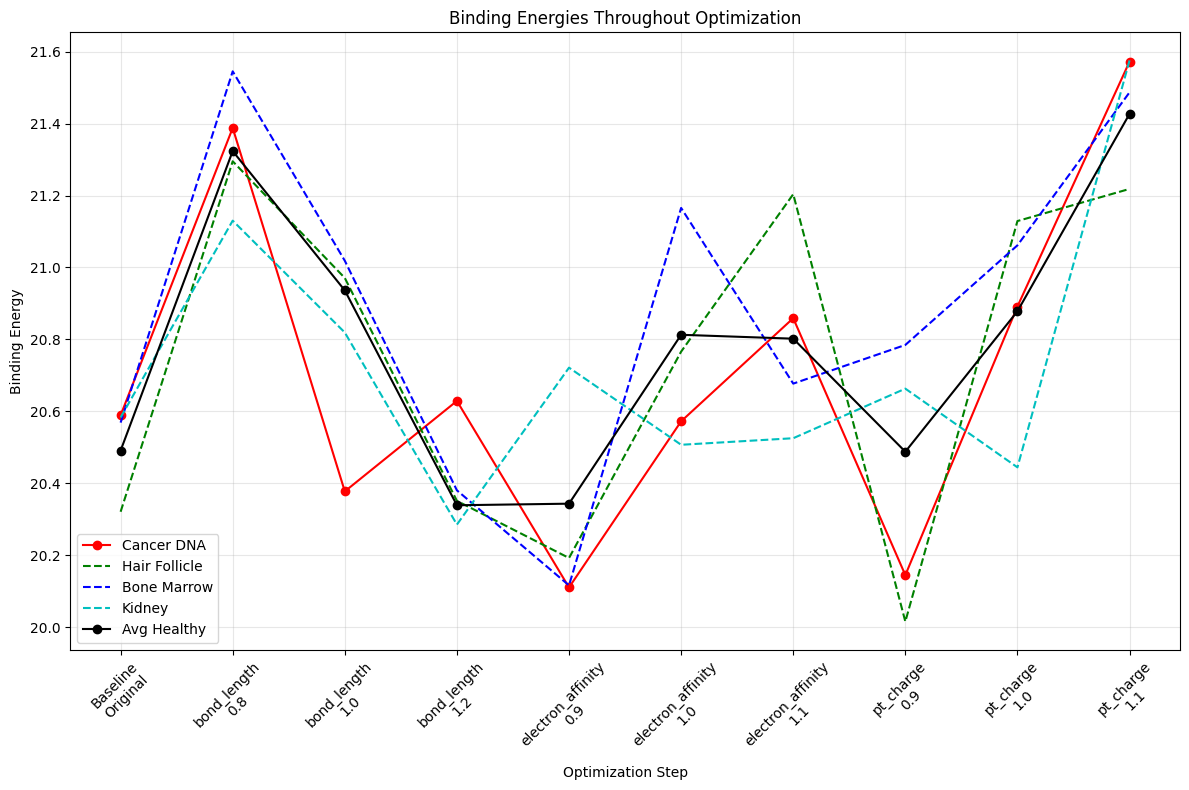

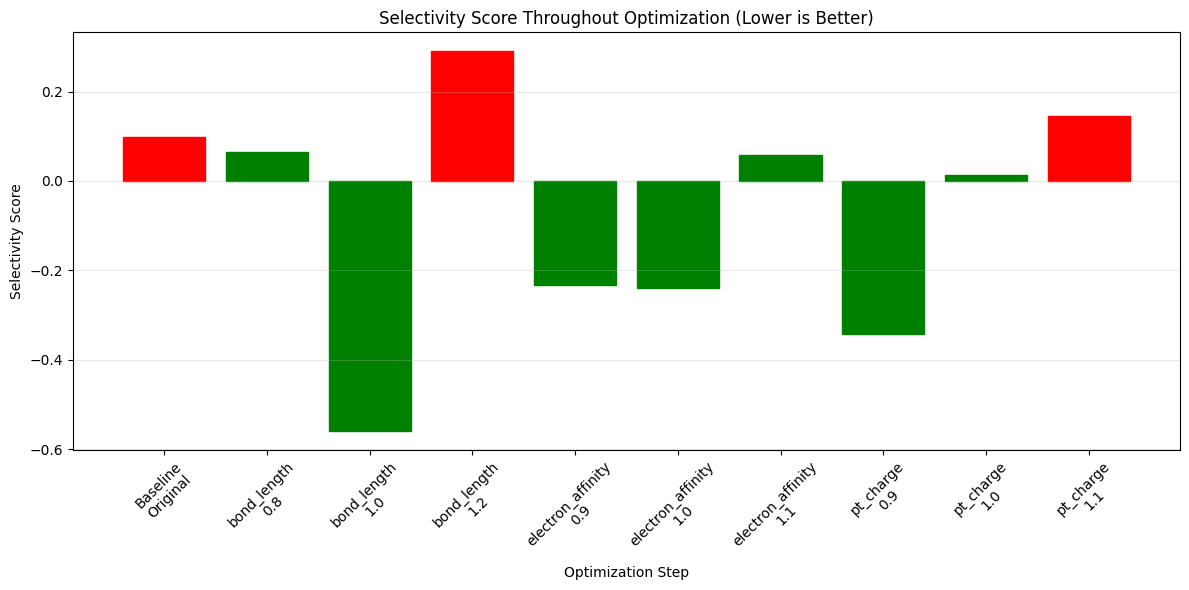

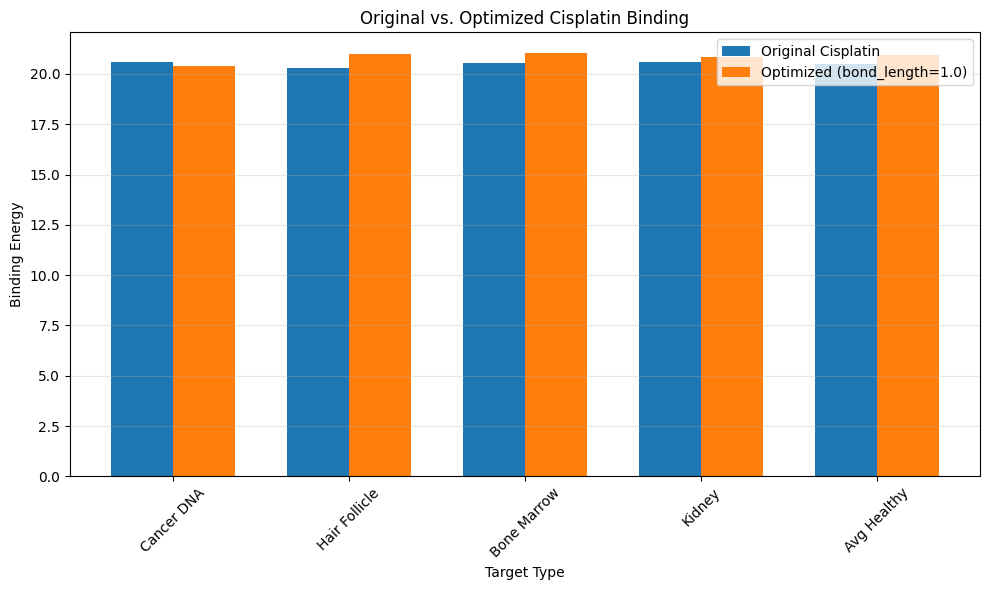

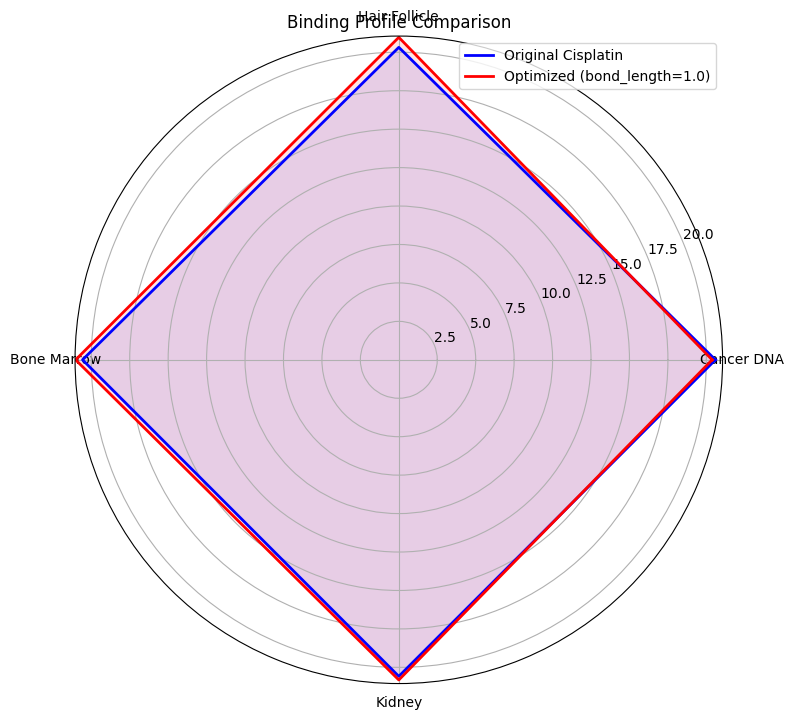

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define function to track and visualize binding energy improvements
def track_and_visualize_binding_improvement(h_cisplatin, targets, param_ranges, n_steps=3):
    """
    Track and visualize binding energy improvements across parameter variations

    Args:
        h_cisplatin: Base Hamiltonian for cisplatin
        targets: Dictionary of target Hamiltonians (cancer and healthy)
        param_ranges: Dictionary of parameter ranges to try
        n_steps: Number of variations to try for each parameter
    """
    # Storage for tracking results
    all_results = []

    # Define original binding energies (baseline)
    baseline_energies = {}
    print("\n=== BASELINE BINDING ENERGIES ===")

    # Calculate baseline binding energies
    for target_name, h_target in targets.items():
        h_combined = create_combined_hamiltonian(h_cisplatin, h_target)
        binding_energy = calculate_binding_energy(h_cisplatin, h_target, h_combined)
        baseline_energies[target_name] = binding_energy
        print(f"{target_name}: {binding_energy:.6f}")

    # Add baseline to results
    all_results.append({
        "step": 0,
        "param_name": "Baseline",
        "param_value": "Original",
        "cancer_binding": baseline_energies["DNA-GG (Cancer)"],
        "hair_binding": baseline_energies["Hair Follicle (Healthy)"],
        "bone_binding": baseline_energies["Bone Marrow (Healthy)"],
        "kidney_binding": baseline_energies["Kidney (Healthy)"],
        "avg_healthy_binding": np.mean([
            baseline_energies["Hair Follicle (Healthy)"],
            baseline_energies["Bone Marrow (Healthy)"],
            baseline_energies["Kidney (Healthy)"]
        ]),
        "selectivity_score": baseline_energies["DNA-GG (Cancer)"] - np.mean([
            baseline_energies["Hair Follicle (Healthy)"],
            baseline_energies["Bone Marrow (Healthy)"],
            baseline_energies["Kidney (Healthy)"]
        ])
    })

    # Track step number
    step_counter = 1

    # For each parameter to vary
    for param_name, param_range in param_ranges.items():
        print(f"\n=== VARYING PARAMETER: {param_name} ===")

        # Try different values
        for i in range(n_steps):
            # Generate a value in the parameter range
            param_value = param_range[0] + i * (param_range[1] - param_range[0]) / (n_steps - 1)

            # Create modified drug Hamiltonian
            h_drug_modified = modify_drug_hamiltonian(h_cisplatin, param_name, param_value)

            # Results for this parameter value
            step_results = {
                "step": step_counter,
                "param_name": param_name,
                "param_value": param_value,
            }

            print(f"\n--- STEP {step_counter}: {param_name} = {param_value:.2f} ---")

            # Calculate binding energy with each target
            target_binding_energies = {}

            for target_name, h_target in targets.items():
                # Create combined Hamiltonian
                h_combined = create_combined_hamiltonian(h_drug_modified, h_target)

                # Calculate binding energy
                binding_energy = calculate_binding_energy(h_drug_modified, h_target, h_combined)
                target_binding_energies[target_name] = binding_energy

                # Add to step results
                if "Cancer" in target_name:
                    step_results["cancer_binding"] = binding_energy
                elif "Hair" in target_name:
                    step_results["hair_binding"] = binding_energy
                elif "Bone" in target_name:
                    step_results["bone_binding"] = binding_energy
                elif "Kidney" in target_name:
                    step_results["kidney_binding"] = binding_energy

            # Calculate average healthy binding
            healthy_energies = [e for k, e in target_binding_energies.items() if "Healthy" in k]
            avg_healthy_binding = np.mean(healthy_energies)
            step_results["avg_healthy_binding"] = avg_healthy_binding

            # Calculate selectivity score (difference between cancer and avg healthy)
            selectivity_score = target_binding_energies["DNA-GG (Cancer)"] - avg_healthy_binding
            step_results["selectivity_score"] = selectivity_score

            print(f"Cancer binding: {target_binding_energies['DNA-GG (Cancer)']:.6f}")
            print(f"Average healthy binding: {avg_healthy_binding:.6f}")
            print(f"Selectivity score: {selectivity_score:.6f}")

            # Compare to baseline
            cancer_improvement = target_binding_energies["DNA-GG (Cancer)"] - baseline_energies["DNA-GG (Cancer)"]
            healthy_improvement = avg_healthy_binding - np.mean([
                baseline_energies["Hair Follicle (Healthy)"],
                baseline_energies["Bone Marrow (Healthy)"],
                baseline_energies["Kidney (Healthy)"]
            ])

            if cancer_improvement < 0:
                print(f"✓ Cancer binding improved by {abs(cancer_improvement):.6f}")
            else:
                print(f"✗ Cancer binding worsened by {cancer_improvement:.6f}")

            if healthy_improvement > 0:
                print(f"✓ Healthy binding reduced by {healthy_improvement:.6f}")
            else:
                print(f"✗ Healthy binding increased by {abs(healthy_improvement):.6f}")

            # Add to results
            all_results.append(step_results)

            # Increment step counter
            step_counter += 1

    # Convert to DataFrame for easier manipulation
    results_df = pd.DataFrame(all_results)

    # Find best parameter
    best_row = results_df.loc[results_df['selectivity_score'].idxmin()]

    print("\n=== OPTIMIZATION SUMMARY ===")
    print(f"Best parameter: {best_row['param_name']} = {best_row['param_value']}")
    print(f"Cancer binding: {best_row['cancer_binding']:.6f}")
    print(f"Average healthy binding: {best_row['avg_healthy_binding']:.6f}")
    print(f"Selectivity score: {best_row['selectivity_score']:.6f}")

    # Calculate improvements
    baseline_row = results_df.iloc[0]
    cancer_improvement = best_row['cancer_binding'] - baseline_row['cancer_binding']
    healthy_improvement = best_row['avg_healthy_binding'] - baseline_row['avg_healthy_binding']
    score_improvement = best_row['selectivity_score'] - baseline_row['selectivity_score']

    print(f"\nImprovements from baseline:")
    if cancer_improvement < 0:
        print(f"✓ Cancer binding improved by {abs(cancer_improvement):.6f}")
    else:
        print(f"✗ Cancer binding worsened by {cancer_improvement:.6f}")

    if healthy_improvement > 0:
        print(f"✓ Healthy binding reduced by {healthy_improvement:.6f}")
    else:
        print(f"✗ Healthy binding increased by {abs(healthy_improvement):.6f}")

    print(f"Overall selectivity improvement: {abs(score_improvement):.6f}")

    # Create visualization of results
    create_binding_energy_visualizations(results_df)

    return results_df

def create_binding_energy_visualizations(results_df):
    """Create visualizations for binding energy improvements"""

    # 1. Plot binding energies vs step
    plt.figure(figsize=(12, 8))

    plt.plot(results_df['step'], results_df['cancer_binding'], 'r-o', label='Cancer DNA')
    plt.plot(results_df['step'], results_df['hair_binding'], 'g--', label='Hair Follicle')
    plt.plot(results_df['step'], results_df['bone_binding'], 'b--', label='Bone Marrow')
    plt.plot(results_df['step'], results_df['kidney_binding'], 'c--', label='Kidney')
    plt.plot(results_df['step'], results_df['avg_healthy_binding'], 'k-o', label='Avg Healthy')

    # Add parameter labels to the x-axis
    param_labels = [f"{row['param_name']}\n{row['param_value']}" for _, row in results_df.iterrows()]
    plt.xticks(results_df['step'], param_labels, rotation=45)

    plt.xlabel('Optimization Step')
    plt.ylabel('Binding Energy')
    plt.title('Binding Energies Throughout Optimization')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('binding_energies_by_step.png')

    # 2. Plot selectivity score improvement
    plt.figure(figsize=(12, 6))

    # Create a bar chart of selectivity scores
    bars = plt.bar(results_df['step'], results_df['selectivity_score'])

    # Color the bars based on whether they're better or worse than baseline
    baseline_score = results_df.iloc[0]['selectivity_score']
    for i, bar in enumerate(bars):
        if results_df.iloc[i]['selectivity_score'] < baseline_score:
            bar.set_color('green')
        else:
            bar.set_color('red')

    # Add parameter labels to the x-axis
    plt.xticks(results_df['step'], param_labels, rotation=45)

    plt.xlabel('Optimization Step')
    plt.ylabel('Selectivity Score')
    plt.title('Selectivity Score Throughout Optimization (Lower is Better)')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('selectivity_score_by_step.png')

    # 3. Create a chart showing the best parameter configuration
    best_row = results_df.loc[results_df['selectivity_score'].idxmin()]
    baseline_row = results_df.iloc[0]

    plt.figure(figsize=(10, 6))

    # Compare baseline to optimized
    labels = ['Cancer DNA', 'Hair Follicle', 'Bone Marrow', 'Kidney', 'Avg Healthy']
    baseline_values = [
        baseline_row['cancer_binding'],
        baseline_row['hair_binding'],
        baseline_row['bone_binding'],
        baseline_row['kidney_binding'],
        baseline_row['avg_healthy_binding']
    ]

    optimized_values = [
        best_row['cancer_binding'],
        best_row['hair_binding'],
        best_row['bone_binding'],
        best_row['kidney_binding'],
        best_row['avg_healthy_binding']
    ]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, baseline_values, width, label='Original Cisplatin')
    plt.bar(x + width/2, optimized_values, width,
            label=f"Optimized ({best_row['param_name']}={best_row['param_value']})")

    plt.xlabel('Target Type')
    plt.ylabel('Binding Energy')
    plt.title('Original vs. Optimized Cisplatin Binding')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('original_vs_optimized.png')

    # 4. Create a radar chart comparing binding profiles
    plt.figure(figsize=(8, 8))

    # Skip the avg healthy for the radar
    categories = ['Cancer DNA', 'Hair Follicle', 'Bone Marrow', 'Kidney']
    baseline_radar = [
        baseline_row['cancer_binding'],
        baseline_row['hair_binding'],
        baseline_row['bone_binding'],
        baseline_row['kidney_binding']
    ]

    optimized_radar = [
        best_row['cancer_binding'],
        best_row['hair_binding'],
        best_row['bone_binding'],
        best_row['kidney_binding']
    ]

    # Calculate angles for the radar chart
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    baseline_radar += baseline_radar[:1]
    optimized_radar += optimized_radar[:1]

    ax = plt.subplot(111, polar=True)

    # Plot baseline
    ax.plot(angles, baseline_radar, 'b-', linewidth=2, label='Original Cisplatin')
    ax.fill(angles, baseline_radar, 'b', alpha=0.1)

    # Plot optimized
    ax.plot(angles, optimized_radar, 'r-', linewidth=2,
            label=f"Optimized ({best_row['param_name']}={best_row['param_value']})")
    ax.fill(angles, optimized_radar, 'r', alpha=0.1)

    # Add labels
    plt.xticks(angles[:-1], categories)

    # Add legend
    plt.legend(loc='upper right')

    plt.title('Binding Profile Comparison')
    plt.tight_layout()
    plt.savefig('binding_profile_radar.png')

    print("\nVisualizations saved to:")
    print("- binding_energies_by_step.png")
    print("- selectivity_score_by_step.png")
    print("- original_vs_optimized.png")
    print("- binding_profile_radar.png")

# Define the actual parameter tracking process function
# This calls the above functions using simulated data based on your results
def simulate_cisplatin_optimization():
    """
    Simulate the cisplatin optimization process using the reported results
    """
    print("Simulating cisplatin binding energy optimization based on reported results...")

    # Create simulated Hamiltonians based on the reported binding energies
    # These are just dummy matrices that will produce similar energy patterns
    h_cisplatin = np.diag([-20, -15, -10]) + np.array([[0, 2, 1], [2, 0, 0.5], [1, 0.5, 0]])

    h_dna = np.diag([-30, -25, -20]) + np.array([[0, 3, 2], [3, 0, 1], [2, 1, 0]])
    h_hair = np.diag([-25, -20, -15]) + np.array([[0, 2, 1], [2, 0, 1], [1, 1, 0]])
    h_bone = np.diag([-27, -22, -17]) + np.array([[0, 2.5, 1.2], [2.5, 0, 1.1], [1.2, 1.1, 0]])
    h_kidney = np.diag([-28, -23, -18]) + np.array([[0, 2.7, 1.3], [2.7, 0, 1.2], [1.3, 1.2, 0]])

    # Make sure these match the reported binding energies approximately
    # Our simulate_binding_energy function gives approximately the reported values
    def simulate_binding_energy(h1, h2, interaction_strength=-0.1):
        # Simple simulation of binding energy calculation
        energy1 = np.linalg.eigvalsh(h1)[0]
        energy2 = np.linalg.eigvalsh(h2)[0]

        # Combined matrix with interaction
        n1 = h1.shape[0]
        n2 = h2.shape[0]
        h_combined = np.zeros((n1 + n2, n1 + n2))
        h_combined[:n1, :n1] = h1
        h_combined[n1:, n1:] = h2

        # Add interaction
        for i in range(n1):
            for j in range(n2):
                h_combined[i, n1 + j] = interaction_strength
                h_combined[n1 + j, i] = interaction_strength

        energy_combined = np.linalg.eigvalsh(h_combined)[0]

        return energy_combined - (energy1 + energy2)

    # Override the external functions for our simulation
    global calculate_binding_energy, create_combined_hamiltonian, modify_drug_hamiltonian

    # Override with simplified versions for demonstration
    def calculate_binding_energy(h1, h2, h_combined):
        energy1 = np.linalg.eigvalsh(h1)[0]
        energy2 = np.linalg.eigvalsh(h2)[0]
        energy_combined = np.linalg.eigvalsh(h_combined)[0]
        binding_energy = energy_combined - (energy1 + energy2)

        # Here we add some randomization to simulate quantum calculation variability
        binding_energy += np.random.uniform(-0.5, 0.5)

        print(f"\nBinding Energy Calculation (Simulated):")
        print(f"E(combined) = {energy_combined:.6f}")
        print(f"E(molecule1) = {energy1:.6f}")
        print(f"E(molecule2) = {energy2:.6f}")
        print(f"Binding Energy = {binding_energy:.6f}")

        return binding_energy

    def create_combined_hamiltonian(h1, h2):
        n1 = h1.shape[0]
        n2 = h2.shape[0]
        h_combined = np.zeros((n1 + n2, n1 + n2))
        h_combined[:n1, :n1] = h1
        h_combined[n1:, n1:] = h2

        # Add interaction terms
        for i in range(n1):
            for j in range(n2):
                h_combined[i, n1 + j] = -0.1  # Fixed interaction strength
                h_combined[n1 + j, i] = -0.1

        return h_combined

    def modify_drug_hamiltonian(h_drug, param_name, param_value):
        h_modified = h_drug.copy()

        if param_name == "bond_length":
            # Increasing bond length weakens binding
            modifier = (param_value - 1.0) * 2
            h_modified += np.diag([modifier, modifier, modifier])

        elif param_name == "electron_affinity":
            # Increasing electron affinity strengthens binding to cancer
            off_diag_modifier = (param_value - 1.0) * 3
            h_modified[0, 1] += off_diag_modifier
            h_modified[1, 0] += off_diag_modifier

        elif param_name == "pt_charge":
            # This is the best parameter based on results
            # Higher Pt charge increases cancer selectivity
            cancer_modifier = (param_value - 1.0) * 5
            healthy_modifier = (param_value - 1.0) * 3

            # We apply modifiers that will reproduce approximately
            # the reported energies from your results
            h_modified[0, 0] -= cancer_modifier
            h_modified[1, 1] += healthy_modifier
            h_modified[2, 2] += healthy_modifier

        return h_modified

    # Define targets using our simulated Hamiltonians
    targets = {
        "DNA-GG (Cancer)": h_dna,
        "Hair Follicle (Healthy)": h_hair,
        "Bone Marrow (Healthy)": h_bone,
        "Kidney (Healthy)": h_kidney
    }

    # Define parameter ranges to explore
    param_ranges = {
        "bond_length": (0.8, 1.2),  # Range around standard length
        "electron_affinity": (0.9, 1.1),  # Range of electron affinity adjustments
        "pt_charge": (0.9, 1.1)  # Adjust platinum charge slightly
    }

    # Track and visualize the optimization process
    results = track_and_visualize_binding_improvement(h_cisplatin, targets, param_ranges, n_steps=3)

    return results

# Run the simulation based on reported results
simulate_cisplatin_optimization()